https://www.kaggle.com/gpreda/santander-eda-and-prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# Introduction
이 challenge에서는 Santander에서 어떤 고객이 거래금액과 관계없이 미래에 특정 거래를 할 것인지 말 것인지에 대해 맞추는 것을 도와주길 바라며 캐글러들을 초대했다. 이 대회에 제공된 데이터는 이 문제를 풀기 위한 실제 데이터와 동일한 구조를 갖고 있다. 데이터는 익명화되어 있고, 각 row는 200개의 수치형 값을 갖고 있다.

# Prepare for data analysis
## Load packages

In [2]:
import gc
import os
import logging
import datetime
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from tqdm import tqdm_notebook

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold


## Load data
어떤 데이터 파일들이 사용가능한지 확인해봅시다!

In [3]:
%%time
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

CPU times: user 17.4 s, sys: 1.35 s, total: 18.8 s
Wall time: 18.8 s


# Data exploration
## Check the data
train data와 test data를 확인해봅시다!

In [4]:
train.shape, test.shape

((200000, 202), (200000, 201))

train data와 test data모두 200000 entry를 갖고 있고, 칼럼은 각각 202,201 개가 있다. train, test를 한 번 살펴보겠습니다

In [5]:
train.head()

ID_code  target    var_0   var_1   ...     var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863   ...      7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473   ...      8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457   ...     -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518   ...     -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834   ...      3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [6]:
test.head()

ID_code    var_0    var_1   ...     var_197  var_198  var_199
0  test_0  11.0656   7.7798   ...     10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543   ...      9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581   ...      7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222   ...      9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327   ...      7.2882  13.9260  -9.1846

[5 rows x 201 columns]

Train Contains:
- **ID_code** (string)
- **target**
- 200개의 (**var_0** ~ **var_199**) 수치형 변수들

Test Contains : 
- **ID_code** (string)
- 200개의 (**var_0** ~ **var_199**) 수치형 변수들

missing data가 있는지 살펴봅시다! 데이터의 타입도 살펴보겠습니다.

In [7]:
def missing_data(data) :
    total = data.isnull().sum()
    percent = total / data.isnull().count()*100
    
    tt = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    
    types = []
    for col in data.columns :
        dtype = str(data[col].dtype)
        types.append(dtype)    
    tt['Types'] = types
    
    return(np.transpose(tt))
    

In [8]:
%%time
missing_data(train)

CPU times: user 1.7 s, sys: 8 ms, total: 1.71 s
Wall time: 1.71 s


ID_code target    var_0   ...     var_197  var_198  var_199
Total         0      0        0   ...           0        0        0
Percent       0      0        0   ...           0        0        0
Types    object  int64  float64   ...     float64  float64  float64

[3 rows x 202 columns]

In [9]:
%%time
missing_data(test)

CPU times: user 1.65 s, sys: 0 ns, total: 1.65 s
Wall time: 1.65 s


ID_code    var_0    var_1   ...     var_197  var_198  var_199
Total         0        0        0   ...           0        0        0
Percent       0        0        0   ...           0        0        0
Types    object  float64  float64   ...     float64  float64  float64

[3 rows x 201 columns]

train data 와 test data의 missing 값이 없습니다. 데이터에 있는 수치형 변수들을 살펴보겠습니다

In [10]:
train.describe()

target          var_0      ...              var_198        var_199
count  200000.000000  200000.000000      ...        200000.000000  200000.000000
mean        0.100490      10.679914      ...            15.870720      -3.326537
std         0.300653       3.040051      ...             3.010945      10.438015
min         0.000000       0.408400      ...             6.299300     -38.852800
25%         0.000000       8.453850      ...            13.829700     -11.208475
50%         0.000000      10.524750      ...            15.934050      -2.819550
75%         0.000000      12.758200      ...            18.064725       4.836800
max         1.000000      20.315000      ...            26.079100      28.500700

[8 rows x 201 columns]

In [11]:
test.describe()

var_0          var_1      ...              var_198        var_199
count  200000.000000  200000.000000      ...        200000.000000  200000.000000
mean       10.658737      -1.624244      ...            15.869184      -3.246342
std         3.036716       4.040509      ...             3.008717      10.398589
min         0.188700     -15.043400      ...             6.584000     -39.457800
25%         8.442975      -4.700125      ...            13.847275     -11.124000
50%        10.513800      -1.590500      ...            15.943400      -2.725950
75%        12.739600       1.343400      ...            18.045200       4.935400
max        22.323400       9.385100      ...            26.538400      27.907400

[8 rows x 200 columns]

여기서 몇 가지를 확인해볼 수 있을 것 같습니다
- train data, test data 모두 standard deviation이 상대적으로 큰 값들이 있습니다.
- 변수별로 train data, test data의 min, max, mean, sd 값들은 거의 비슷해 보입니다.
- 평균 값들은 넓게 분포되어 있습니다.

train data와 test data의 피쳐들별로 산점도를 그려봅시다

In [12]:
def plot_feature_scatter(df1, df2, features) :
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4, figsize = (14,14))
    
    for feature in features :
        i+=1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker = '+') 
        plt.xlabel(feature, fontsize = 9)
        
    plt.show()

전체 데이터의 5%만 그려보겠습니다. x축에는 train data의 값을 y축에는 test data의 값을 그리겠습니다.

<Figure size 432x288 with 0 Axes>

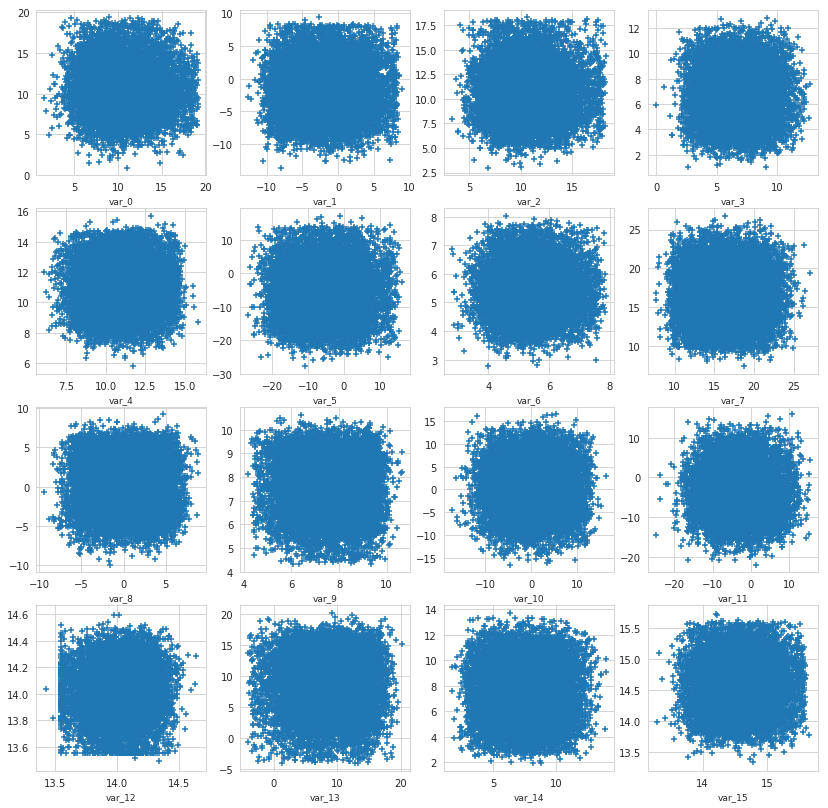

In [13]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]

plot_feature_scatter(train[::20], test[::20], features)

train data 의  target값의 분포를 확인해봅시다

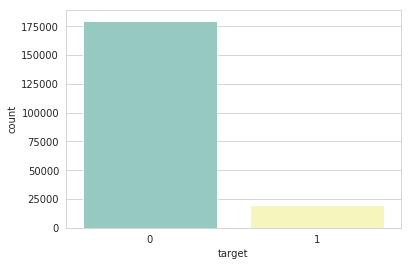

In [16]:
 sns.countplot(train.target, palette='Set3')

In [17]:
print('target value에서 1의 비율은 {}%입니다'.format(100*train['target'].value_counts()[1] / train.shape[0]))

target value에서 1의 비율은 10.049%입니다


target value의 관점에서 보면 불균형한 데이터입니다

## Density plots of features
train data의 density plot을 그려보겠습니다. target 값의 0과 1을 다른 색깔로 분포를 그려보겠습니다.

In [19]:
def plot_feature_distribution(df1, df2, label1, label2, features) :
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10, figsize = (18,22))
    
    for feature in features :
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist = False, label = label1)
        sns.distplot(df2[feature], hist = False, label = label2)
        plt.xlabel(feature, fontsize = 9)
        
        #Change the appearance of ticks, tick labels, and gridlines.
        plt.tick_params(axis = 'x', which = 'major', labelsize = 6, pad = -6) #pad : tick과 label과의 거리
        plt.tick_params(axis = 'y', which = 'major', labelsize = 6)
    plt.show()

<Figure size 432x288 with 0 Axes>

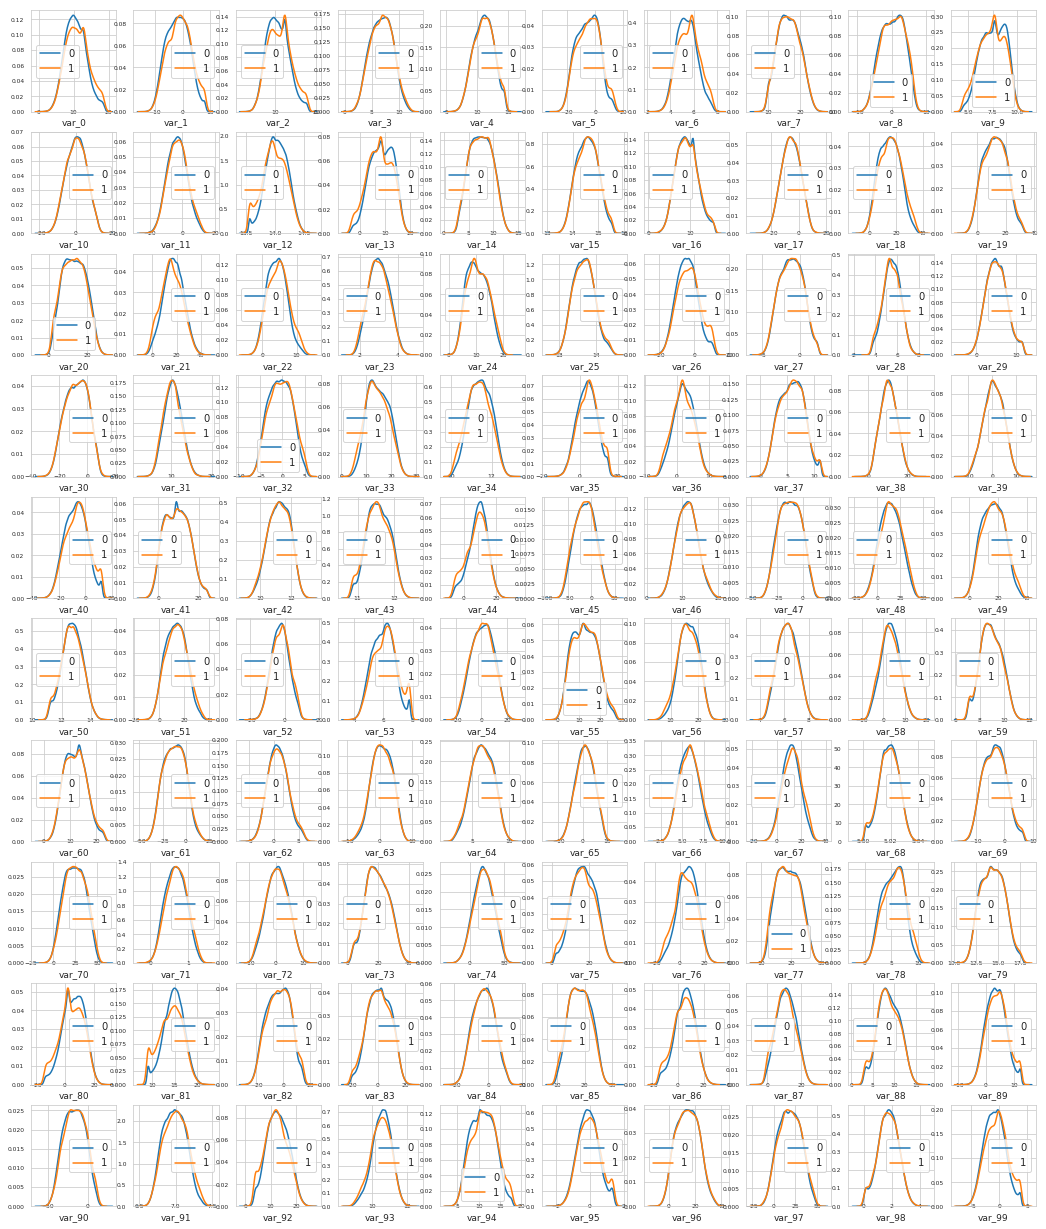

In [20]:
#처음 100개 features
t0 = train[train.target == 0]
t1 = train[train.target == 1]

features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

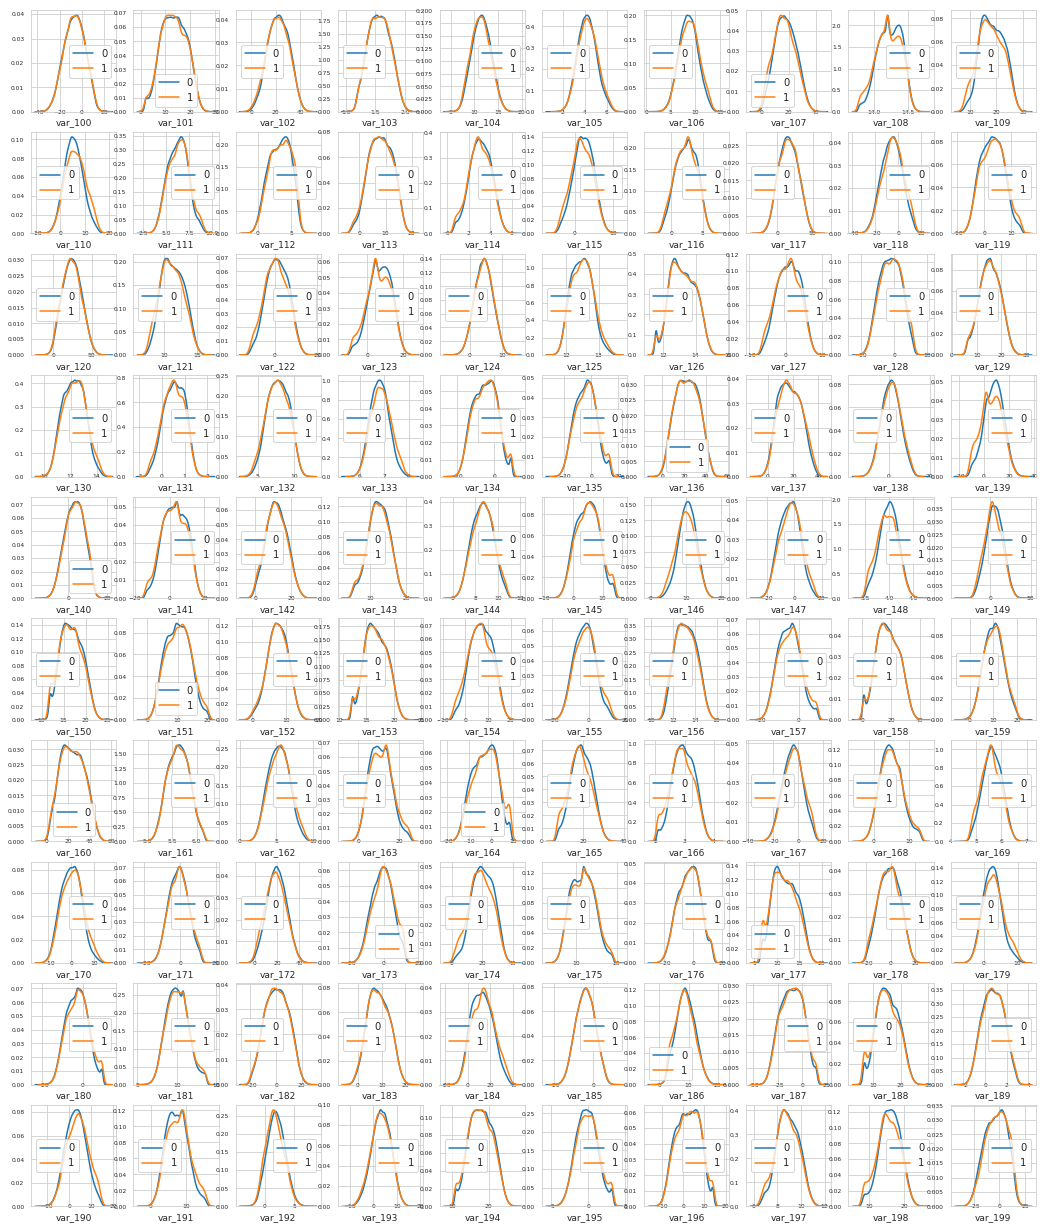

In [21]:
#다음 100개 features
features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

상당한 수의 feature들이 두 타겟 값(0,1)에 따라 다른 분포를 보이는 것을 볼 수 있다. 예를 들어 var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139
또 어떤 var_2, var_13, var_26, var_55, var_175, var_184, var_196와 같은 feature들은 bivariate distribution처럼 보인다
이러한 점들을 염두해 두고 예측 모델링시 피쳐선택을 하겠다. 

train, test data별로 feature들을 살펴 보자

<Figure size 432x288 with 0 Axes>

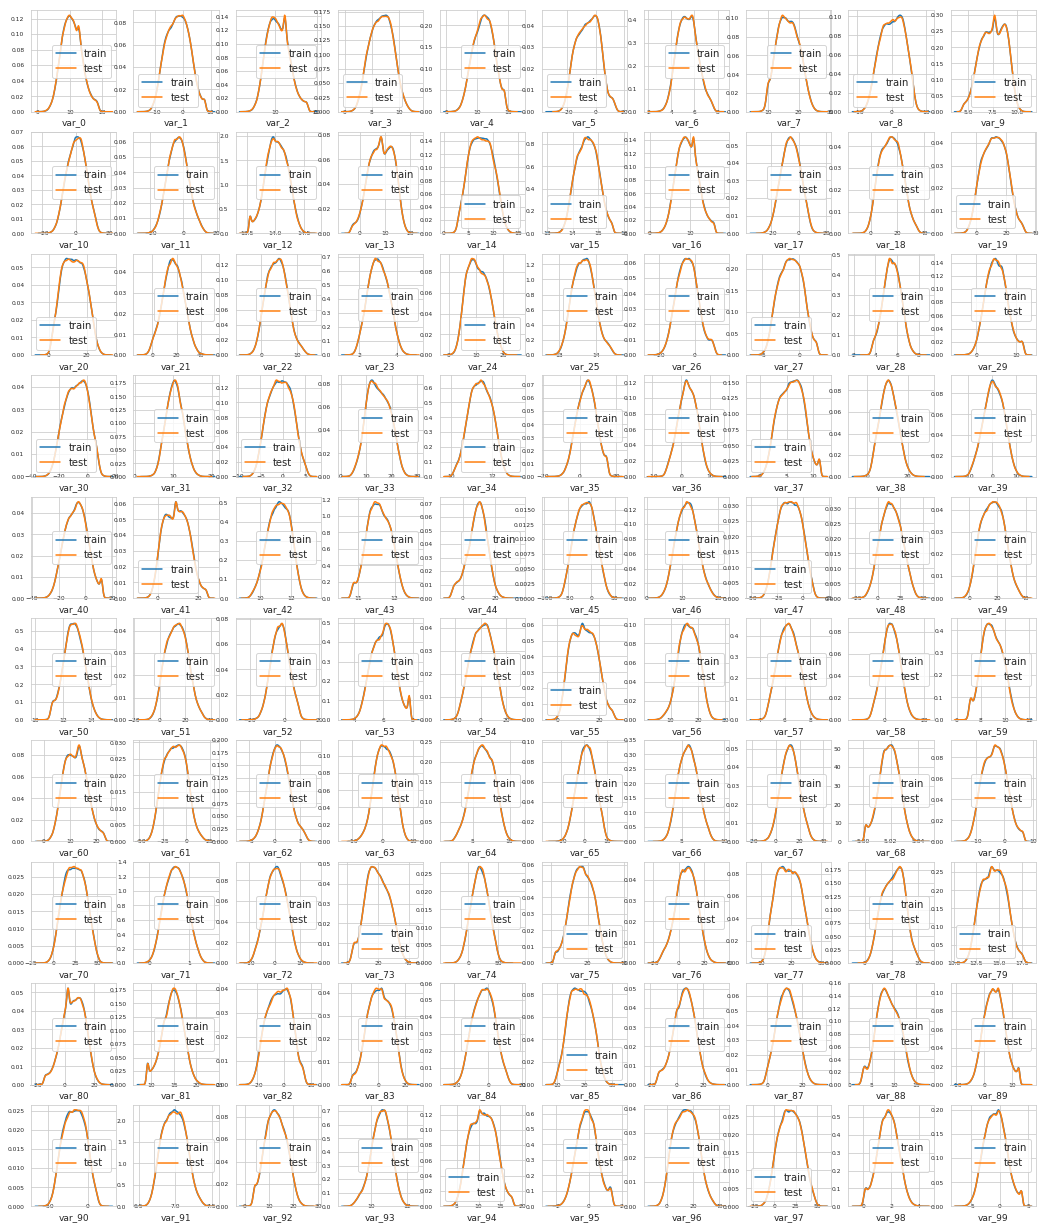

In [23]:
features = train.columns.values[2:102]
plot_feature_distribution(train, test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

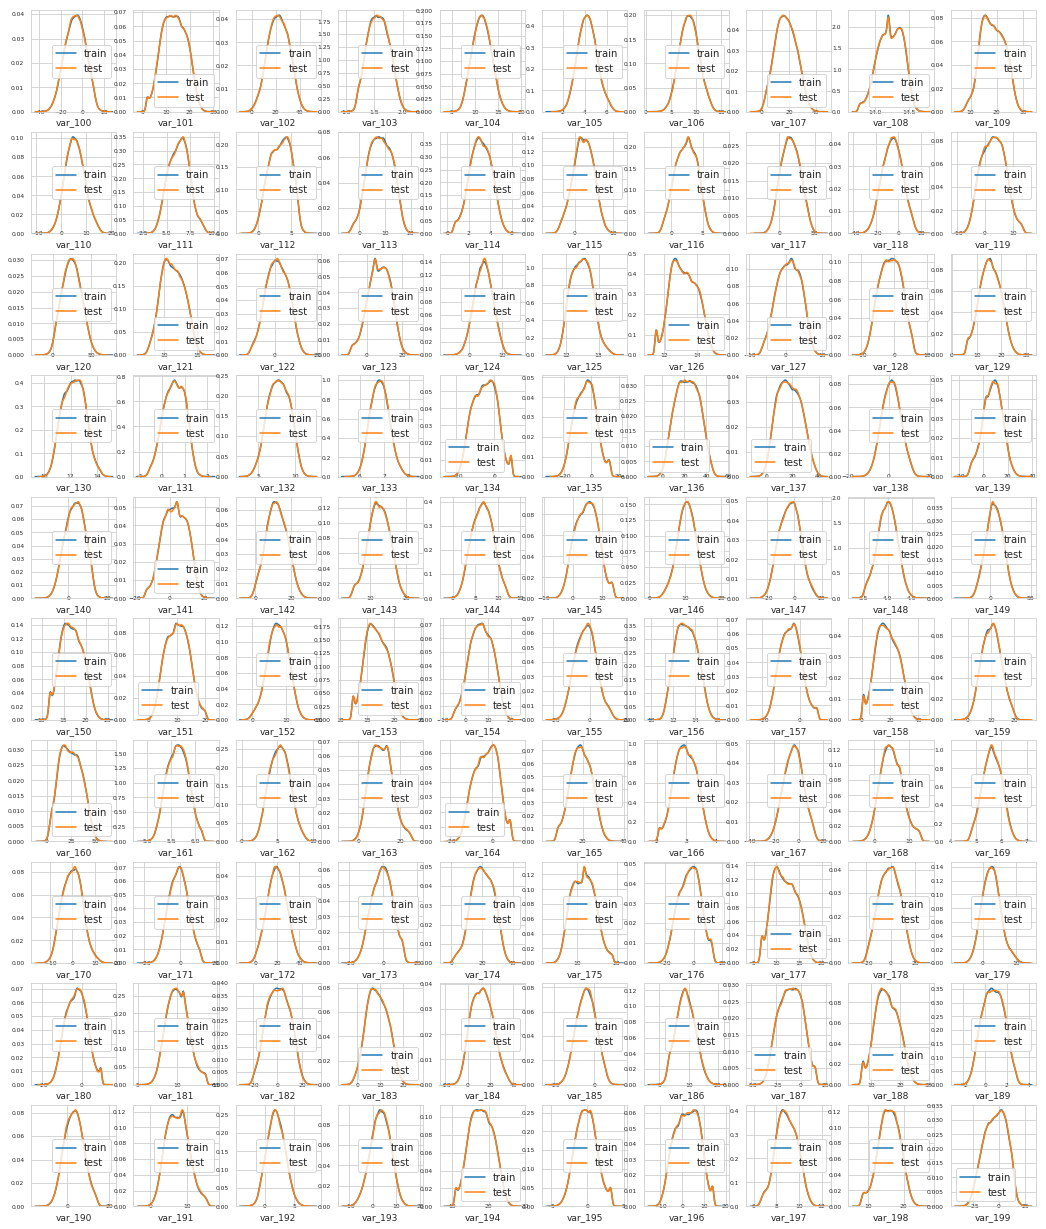

In [24]:
features = train.columns.values[102:202]
plot_feature_distribution(train, test, 'train', 'test', features)

train과 test data는 수치형 값들의 분포의 관점에서 봤을 때, 굉장히 잘 균형있게 분포되어 있다

## Distribution of mean and std
train data와 test data의 행(row) 별 평균값을 확인해보자

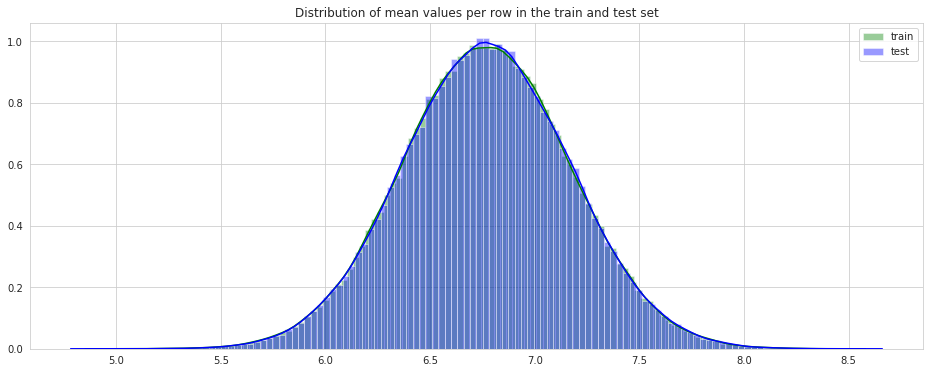

In [30]:
plt.figure(figsize = (16,6))
features = train.columns.values[2:202] #ID와 target값을 뺀 모든 칼럼
plt.title('Distribution of mean values per row in the train and test set')

sns.distplot(train[features].mean(axis = 1), color = 'green', kde = True, bins = 120, label = 'train')
sns.distplot(test[features].mean(axis = 1), color = 'blue', kde = True, bins = 120, label = 'test')
#kde : kernel density estimate(커널 밀도 추정) True로 해주면, distribution plot에 smoothing곡선이 생김
plt.legend()
plt.show()

train data와 test data의 열(column) 별 평균값을 확인해보자

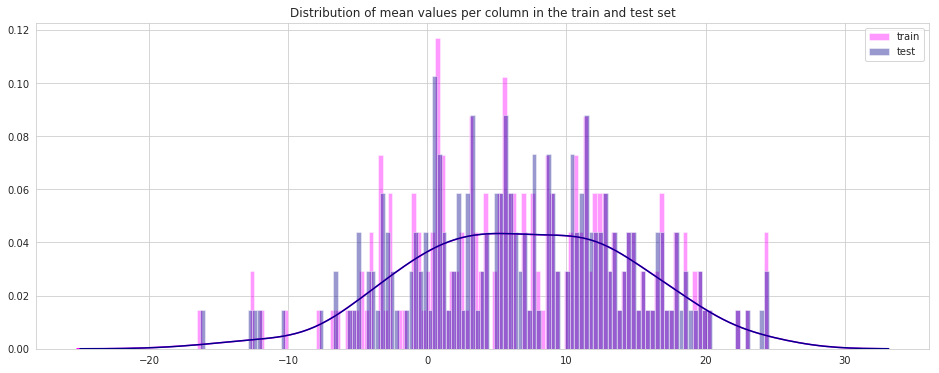

In [33]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

train data와 test data의 행(row) 별 표준편차(sd)를 확인해보자

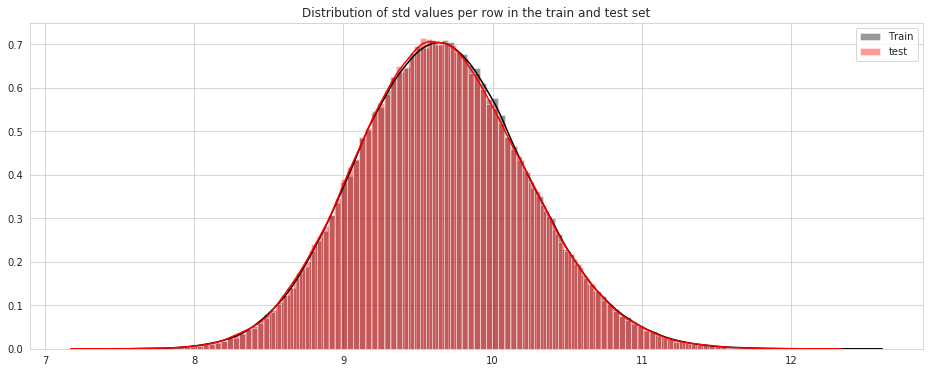

In [36]:
plt.figure(figsize=(16,6))
plt.title('Distribution of std values per row in the train and test set')
sns.distplot(train[features].std(axis = 1), color = 'black', kde = True, bins = 120, label = 'Train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

train data와 test data의 열(column) 별 표준편차(sd)를 확인해보자

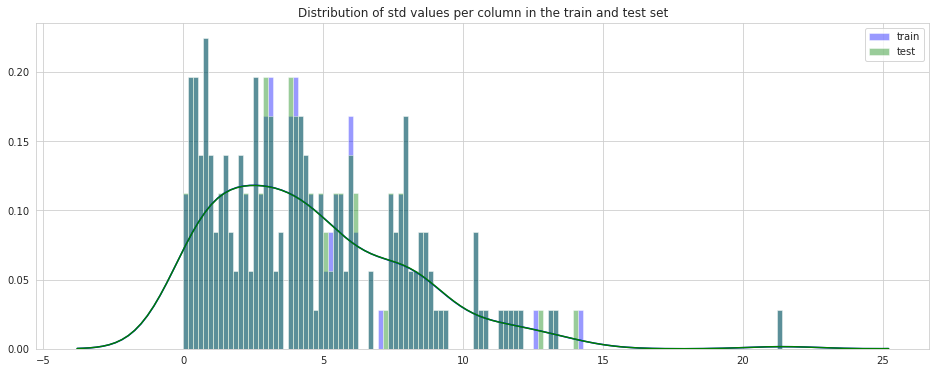

In [38]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()